<a href="https://colab.research.google.com/github/Original-2/Equinox_Examples/blob/main/3D_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D image classification from CT scans

Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [5]:
!pip install equinox
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import os
import zipfile
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
from tqdm import trange
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
import copy

key = jax.random.PRNGKey(123)

In [7]:
batch_size = 2

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [8]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
!wget https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip

# Make a directory to store the data.
try:
  os.makedirs("MosMedData")
except:
  pass
# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [9]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


Let's read the paths of the CT scans from the class directories.

In [10]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [11]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = jnp.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = jnp.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
normal_labels = jnp.array([0 for _ in range(len(normal_scans))])
abnormal_labels = jnp.array([1 for _ in range(len(abnormal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = jnp.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = jnp.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = jnp.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = jnp.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [12]:
def scipy_rotate(volume, key):
    # define some rotation angles
    angles = jnp.array([-20, -10, -5, 5, 10, 20])
    # pick angles at random
    angle = jax.random.choice(key, angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

Visualize an augmented CT scan.

Dimension of the CT scan is: (128, 128, 64)


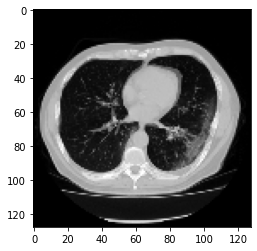

In [13]:
image =  x_train[0]
labels = y_train[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(jnp.squeeze(image[:, :, 30]), cmap="gray")

Since a CT scan has many slices, let's visualize a montage of the slices.

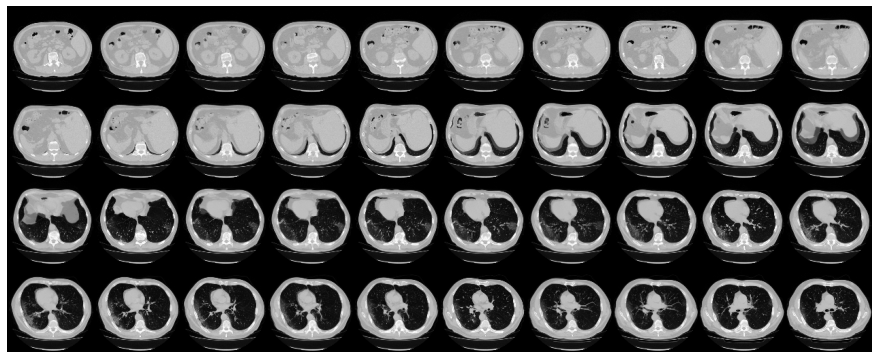

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = jnp.rot90(jnp.array(data))
    data = jnp.transpose(data)
    data = jnp.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [15]:
class cnn3d(eqx.Module):
    conv: list
    norm: list
    dense: list
    drop: eqx.nn.Dropout


    def __init__(
        self,
        *,
        key,
    ):
        key1, key2, key3 = jax.random.split(key, 3)

        self.conv = [eqx.nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, key=key1),
                    eqx.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, key=key2),
                    eqx.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, key=key2),
                    eqx.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, key=key2),
                    ]
        self.norm = [eqx.nn.LayerNorm((64, 63, 63, 31)),
                    eqx.nn.LayerNorm((64, 30, 30, 14)),
                    eqx.nn.LayerNorm((128, 14, 14, 6)),
                    eqx.nn.LayerNorm((256, 6, 6, 2)),
                    ]

        self.dense = [eqx.nn.Linear(256, 512, key=key3),
                    eqx.nn.Linear(512, 1, key=key3),
                    ]

        self.drop = eqx.nn.Dropout(0.3)

    def __call__(self, x, key, inference=False):
        x = jax.nn.relu(self.conv[0](x))
        x = eqx.nn.AvgPool3D(2, 2)(x)
        x = self.norm[0](x)

        x = jax.nn.relu(self.conv[1](x))
        x = eqx.nn.AvgPool3D(2, 2)(x)
        x = self.norm[1](x)

        x = jax.nn.relu(self.conv[2](x))
        x = eqx.nn.AvgPool3D(2, 2)(x)
        x = self.norm[2](x)

        x = jax.nn.relu(self.conv[3](x))
        x = eqx.nn.AvgPool3D(2, 2)(x)
        x = self.norm[3](x)

        x = jnp.apply_over_axes(jnp.mean, x, [1,2,3]).flatten()

        x = jax.nn.relu(self.dense[0](x))
        x = self.drop(x, key=key)
        x = self.dense[1](x)
        return jax.nn.sigmoid(x)

key, temp, *drkeys = jax.random.split(key,2+batch_size)
model = cnn3d(key=key)

jnp.shape(jax.vmap(model, axis_name="b")(jnp.reshape(x_train[:batch_size], (batch_size, 1, 128, 128, 64)), jnp.array(drkeys)))

(2, 1)

In [16]:
1==1

True

## Train model

In [17]:
def main(
    learning_rate=0.00001,
    steps=len(x_train)//batch_size,
    val_steps=len(x_val)//batch_size,
    seed=6969,
    epochs=100,
    patience=15
):
    metrics_val = {"loss":[], "accuracy":[]}
    metrics_train = {"loss":[]}

    best_acc = 0
    stagnation_counter = 0

    key = jax.random.PRNGKey(seed)
    key, temp = jax.random.split(key, 2)
    model = cnn3d(key=temp)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y, key):
        predy = jax.vmap(model, axis_name="b")(x, key=jnp.array(key))    
        losses = -jnp.mean(y * jnp.log(predy) + (1 - y) * jnp.log(1 - predy))
        return losses

    @eqx.filter_jit
    def make_step(model, x, y, opt_state, key):
        loss, grads = compute_loss(model, x, y, key)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    def compute_metrics(model, x, y, key):
        predy = jax.vmap(model, axis_name="b")(x, key=jnp.array(key))    
        losses = -jnp.mean(y * jnp.log(predy) + (1 - y) * jnp.log(1 - predy))

        accuracy = jnp.mean(jnp.round(predy) == y)
        return losses, accuracy

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)
    for epoch in range(epochs):
        if stagnation_counter == patience:
          break
        else:
          key, orderkey = jax.random.split(key, 2)
          order = jax.random.permutation(orderkey, 140)
          bar = trange(steps)
          metrics = {"loss":[]}
          for i in bar:
              bar.set_description(f"epoch {epoch+1}")
              start = i*batch_size
              stop = i*batch_size+batch_size

              xs = []
              ys = []
              for j in range(batch_size):
                key, rotkey = jax.random.split(key, 2)
                xs.append(jnp.reshape(scipy_rotate(x_train[order[start+batch_size]],rotkey), (1, 128, 128, 64)))
                ys.append(y_train[order[start+batch_size]])

              key, *bkeys = jax.random.split(key, batch_size+1)
              loss, model, opt_state = make_step(model, jnp.array(xs), jnp.array(ys), opt_state, bkeys)

              bar.set_postfix(loss=loss)

              metrics["loss"].append(loss)
          metrics_train["loss"].append(jnp.mean(jnp.array(metrics["loss"])))

          ### compute metrics ###

          metrics = {"loss":[],
                    "accuracy":[]}

          for i in range(val_steps):
            start = i*batch_size
            stop = i*batch_size+batch_size

            xs = list(x_val[start:stop])
            for j in range(batch_size):
              xs[j] = jnp.reshape(xs[j], (1,128,128,64))

            key, *bkeys = jax.random.split(key, batch_size+1)

            l = compute_metrics(model, jnp.array(xs), y_val[start:stop], bkeys)

            metrics["loss"].append(l[0])
            metrics["accuracy"].append(l[1])


          if jnp.mean(jnp.array(metrics["accuracy"])) > best_acc:
            best_acc = jnp.mean(jnp.array(metrics["accuracy"]))
            stagnation_counter = 0
            best_model = copy.deepcopy(model)
          else:
            stagnation_counter += 1

          print("loss: " + str(jnp.mean(jnp.array(metrics["loss"]))) + ", accuracy: " + str(100*jnp.mean(jnp.array(metrics["accuracy"]))) + "%")
          metrics_val["loss"].append(jnp.mean(jnp.array(metrics["loss"])))
          metrics_val["accuracy"].append(100*jnp.mean(jnp.array(metrics["accuracy"])))

    return best_model, metrics_val, metrics_train

In [18]:
model, mericsval, metricstrain = main() 

epoch 1: 100%|██████████| 70/70 [00:37<00:00,  1.89it/s, loss=0.7162756]


loss: 0.6830328, accuracy: 51.66667%


epoch 2: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s, loss=0.72165406]


loss: 0.68705976, accuracy: 55.0%


epoch 3: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.541104]


loss: 0.66337645, accuracy: 60.000004%


epoch 4: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s, loss=1.2114949]


loss: 0.6981127, accuracy: 51.66667%


epoch 5: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s, loss=0.5930619]


loss: 0.67181414, accuracy: 55.0%


epoch 6: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.32136393]


loss: 0.6764329, accuracy: 56.66667%


epoch 7: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s, loss=0.6767481]


loss: 0.6757949, accuracy: 58.333336%


epoch 8: 100%|██████████| 70/70 [00:29<00:00,  2.40it/s, loss=1.141299]


loss: 0.65531456, accuracy: 61.666668%


epoch 9: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s, loss=0.4598666]


loss: 0.70303684, accuracy: 56.66667%


epoch 10: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s, loss=0.43975878]


loss: 0.75278664, accuracy: 51.66667%


epoch 11: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s, loss=0.3132124]


loss: 0.6616734, accuracy: 56.66667%


epoch 12: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.5438421]


loss: 0.6778484, accuracy: 56.66667%


epoch 13: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s, loss=1.1075737]


loss: 0.70191586, accuracy: 60.000004%


epoch 14: 100%|██████████| 70/70 [00:28<00:00,  2.43it/s, loss=0.449915]


loss: 0.6583902, accuracy: 63.33334%


epoch 15: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.32656953]


loss: 0.6752492, accuracy: 58.333336%


epoch 16: 100%|██████████| 70/70 [00:29<00:00,  2.36it/s, loss=0.8490937]


loss: 0.73187196, accuracy: 55.0%


epoch 17: 100%|██████████| 70/70 [00:29<00:00,  2.41it/s, loss=0.4320422]


loss: 0.65819293, accuracy: 56.66667%


epoch 18: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.6409453]


loss: 0.70070916, accuracy: 58.333336%


epoch 19: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s, loss=0.5254865]


loss: 0.66894853, accuracy: 60.000004%


epoch 20: 100%|██████████| 70/70 [00:34<00:00,  2.03it/s, loss=0.21877812]


loss: 0.6668835, accuracy: 63.33334%


epoch 21: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.19046235]


loss: 0.66551304, accuracy: 56.66667%


epoch 22: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s, loss=1.0720068]


loss: 0.6708679, accuracy: 60.000004%


epoch 23: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.3817072]


loss: 0.6518916, accuracy: 56.66667%


epoch 24: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.36432168]


loss: 0.66101253, accuracy: 55.0%


epoch 25: 100%|██████████| 70/70 [00:33<00:00,  2.10it/s, loss=0.6918326]


loss: 0.66307455, accuracy: 60.000004%


epoch 26: 100%|██████████| 70/70 [00:29<00:00,  2.36it/s, loss=0.49051845]


loss: 0.668357, accuracy: 58.333336%


epoch 27: 100%|██████████| 70/70 [00:31<00:00,  2.24it/s, loss=0.63323855]


loss: 0.6588875, accuracy: 61.666668%


epoch 28: 100%|██████████| 70/70 [00:28<00:00,  2.42it/s, loss=0.9930697]


loss: 0.6842839, accuracy: 60.000004%


epoch 29: 100%|██████████| 70/70 [00:29<00:00,  2.35it/s, loss=0.33824995]


loss: 0.68168586, accuracy: 60.000004%


## Make predictions on a single CT scan

In [19]:
key, temp = jax.random.split(key,2)
prediction = jax.vmap(model)(jnp.reshape(x_val[0], (1, 1, 128, 128, 64)), jnp.array([temp]))
#model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

if y_val[0] == 1:
  print("it is abnormal")
else:
  print("it is normal")

This model is 48.44 percent confident that CT scan is normal
This model is 51.56 percent confident that CT scan is abnormal
it is abnormal


## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Accuracy has only been measured for the validation set.

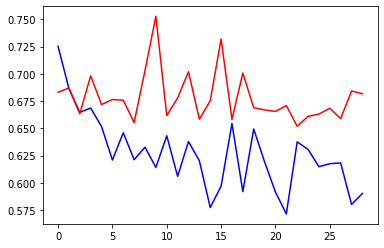

In [20]:
plt.plot(metricstrain["loss"], color = "b")
plt.plot(mericsval["loss"], color="r")
plt.show() 

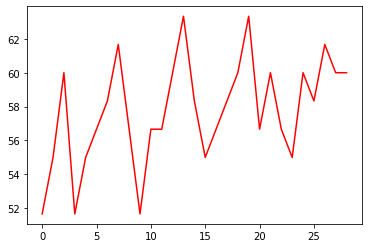

In [21]:
plt.plot(mericsval["accuracy"], color="r")
plt.show() 